In [1]:
import pandas as pd 
import numpy as np 
import scipy
import time
import os
import argparse
from tqdm import tqdm
import copy

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
# Defualt size of the plots
plt.rcParams["figure.figsize"] = (10, 8)
#
%matplotlib inline  

# feature preprocessing 
import category_encoders as ce
import nltk 
# IMPORT SOME MORE TEXT PREPROCESSORS 

# images 
import PIL
import skimage
import albumentations as A
import cv2

# classic ML
import sklearn as sk 
import catboost as cat
import xgboost as xgb
import lightgbm as lgb

# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import transformers 
import lightning.pytorch as pl
from lion_pytorch import Lion


# CV
# from torchvision import transforms

# parallelization
import joblib

# my lib
import pqlib.utils as pq
from pqlib.utils import get_datetime_str

In [2]:
# pq.get_datetime_str()

In [3]:
from sklearn.metrics import roc_auc_score

def METRIC(y_true, model_output):
    model_output = np.array(model_output)
    # removing nan class column
    preds_probas = np.delete(model_output.reshape(-1,4).squeeze(), 0, axis=1)
    # softmax for preds
    preds_probas = scipy.special.softmax(preds_probas, axis=1)
    
    return roc_auc_score(y_true, preds_probas, multi_class="ovr")

#  Medium tutorial


In [4]:
import pandas as pd

In [5]:
# datapath = 'bbc-text.csv'
# df = pd.read_csv(datapath)
# df.head()

In [6]:
datapath = 'train.csv'
df = pd.read_csv(datapath, index_col=0)
df.head()


,sentence,1category,2category,sentiment
4754,При этом всегда получал качественные услуги.,Communication,NaN,+
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
11640,Отвратительное отношение к клиентам.,Communication,NaN,−
5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+


In [7]:
TARGET = 'sentiment'
TEXT = 'sentence'

In [8]:
# Max length of a sequence
lengths_text = df[TEXT].apply(len).values
max_length = max(lengths_text)
print("Max length of a sequence")
print(max_length)

Max length of a sequence
1155


In [9]:
df[(df[TEXT].apply(len) == max_length)]

,sentence,1category,2category,sentiment
15839,4) КОНТРОЛЬ ЗА ОПЕРАЦИЯМИ - при попытки оплати...,Quality,NaN,−
17808,4) КОНТРОЛЬ ЗА ОПЕРАЦИЯМИ - при попытки оплати...,Quality,NaN,−
18935,4) КОНТРОЛЬ ЗА ОПЕРАЦИЯМИ - при попытки оплати...,Quality,Communication,−


In [10]:
df.loc[15839].sentence

'4) КОНТРОЛЬ ЗА ОПЕРАЦИЯМИ - при попытки оплатить товар через интернет, карту временно заблокировали позвонили с банка узнать, что за операции Я пытаюсь совершить/ после уточнении данных по карте, паспорту и ключевому слову - карту разблокировали/ после данного инцидента желание совершать операции через интернет пропали\xa05) СЛОЖНО ЗАБРАТЬ СВОИ ДЕНЬГИ - спустя 3 месяца пользования, карта перестала работать совсем и крайне сильно подвела Меня, когда Я находился в отпуске, доставив массу трудностей в связи ограниченной наличностью/ терпеть подобный «сервис» Я устал и решил сегодня закрыть счет с вместе с картой/ в итоге в отделении банке сказали, что, чтобы снять всю наличность через кассу, Мне нужна работающая карта, так как без Нее Мне не могут отдать сумму и в этом случае нужен ее перевыпуск (который естественно платный) или же Они могу сделать перевод на счет в другой банк, что Мне совершенно не нужно и нет такой такой возможности... ИТОГ: с таким ужасным сервисом и отношение к клие

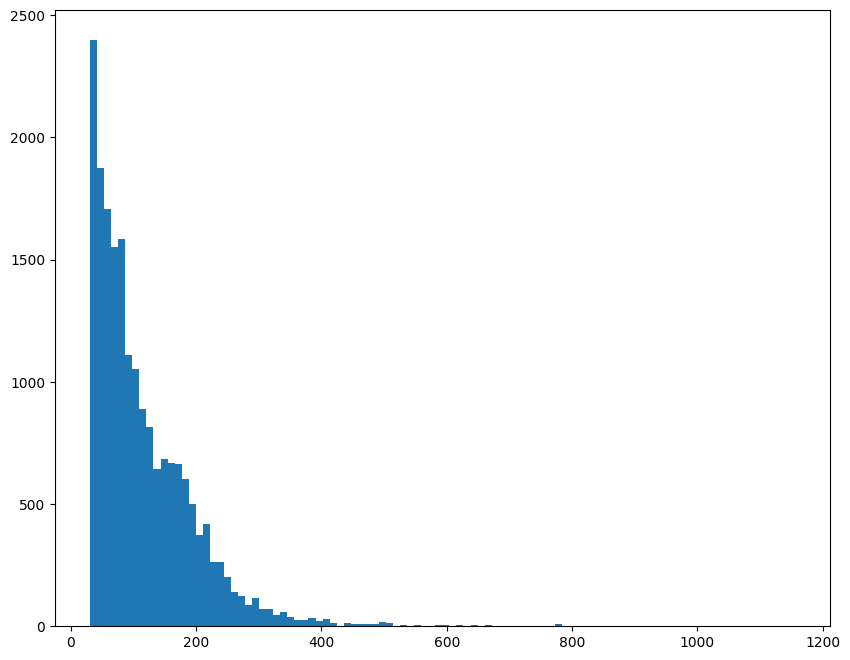

In [11]:
plt.hist(lengths_text,bins=100);

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19361 entries, 4754 to 8433
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   19361 non-null  object
 1   1category  19361 non-null  object
 2   2category  999 non-null    object
 3   sentiment  19361 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [13]:
df.isna().sum()

sentence         0
1category        0
2category    18362
sentiment        0
dtype: int64

In [14]:
df.duplicated().sum()

6464

In [15]:
for col_ in df.columns.drop(TEXT):
    print(f'########## {col_} ##########')
    print(df[col_].value_counts())
    print()

########## 1category ##########
Communication    7193
?                5926
Quality          5630
Price             366
Safety            246
Name: 1category, dtype: int64

########## 2category ##########
Communication    474
Quality          356
Price            114
Safety            55
Name: 2category, dtype: int64

########## sentiment ##########
−    10192
+     6262
?     2907
Name: sentiment, dtype: int64



In [16]:
print(f"Duplicates - all cols - {df.duplicated().sum()}")

for col_ in df.columns:
    print(f'########## {col_} ##########')
    print(df[col_].duplicated().sum())
    print()

Duplicates - all cols - 6464
########## sentence ##########
12195

########## 1category ##########
19356

########## 2category ##########
19356

########## sentiment ##########
19358



In [17]:
df[df.duplicated(keep=False)].sort_values(by=df.columns.values.tolist())

,sentence,1category,2category,sentiment
13334,10.12.2020 20:57 Хотелось бы выразить огромну...,Quality,NaN,+
14601,10.12.2020 20:57 Хотелось бы выразить огромну...,Quality,NaN,+
15048,10.12.2020 20:57 Хотелось бы выразить огромну...,Quality,NaN,+
4481,"!, тем самым оставив меня без средств к сущест...",?,NaN,−
3926,"!, тем самым оставив меня без средств к сущест...",?,NaN,−
...,...,...,...,...
7241,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",Communication,NaN,?
7214,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",Communication,NaN,?
20234,№ ДО 53/Ф20-04-07/1333 от 19.09.2018 и также в...,?,NaN,?
20075,№ ДО 53/Ф20-04-07/1333 от 19.09.2018 и также в...,?,NaN,?


In [18]:
df = df.drop_duplicates()

In [19]:
ord_enc_cols_ = [TARGET]
ord_enc = ce.OrdinalEncoder(
    cols=ord_enc_cols_,
)
ord_enc.fit(df)


OrdinalEncoder(cols=['sentiment'],
               mapping=[{'col': 'sentiment', 'data_type': dtype('O'),
                         'mapping': +      1
−      2
?      3
NaN   -2
dtype: int64}])

In [20]:
ord_enc.transform(df)

,sentence,1category,2category,sentiment
4754,При этом всегда получал качественные услуги.,Communication,NaN,1
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,2
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,2
11640,Отвратительное отношение к клиентам.,Communication,NaN,2
5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,1
...,...,...,...,...
3238,Деньги за страховой полис не вернули до сих по...,?,NaN,2
13273,"Хотелось бы так же прояснить, что до сложившей...",Quality,NaN,1
19523,"""РОСГОССТРАХ - БАНК"" - звучит круто и заманчиво!",?,NaN,1
8004,Никогда и ни в коем случае не открывайте счет ...,Communication,NaN,2


In [21]:
# Getting a mapping of the TARGET variable
labels = ord_enc.mapping[0]['mapping'].to_dict()

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

In [23]:
example_text = 'Мне будет тебя не хватать.'
model_input = tokenizer(example_text,padding='max_length', max_length = 14, 
                       truncation=True, return_tensors="pt")


print(model_input['input_ids'])
# print(model_input['token_type_ids'])
print(model_input['attention_mask'])

tensor([[    1,  7476,   821,   998,   332, 36666,    18,     2,     0,     0,
             0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])


In [24]:
example_text = tokenizer.decode(model_input.input_ids[0])

print(example_text)

<s>Мне будет тебя не хватать.</s><pad><pad><pad><pad><pad><pad>


In [25]:
import torch
import numpy as np
from transformers import BertTokenizer, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')
labels = labels

class DatasetText(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in tqdm(df[TARGET], desc='Labels')]
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt"
                               ) 
                      for text in tqdm(df[TEXT], desc='Tokens')
                     ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [26]:
df.shape

(12897, 4)

In [27]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

10317 1290 1290


In [28]:
# q = DatasetText(df)
# q[0]

In [29]:
from torch import nn
from transformers import BertModel, XLMRobertaForSequenceClassification, AutoModelForSequenceClassification, AutoModel

class SeqClassifier(nn.Module):

    def __init__(self, num_out_classes, dropout=0.5):

        super(SeqClassifier, self).__init__()

#         self.backbone = AutoModel.from_pretrained('xlm-roberta-base')
        self.backbone = AutoModel.from_pretrained('sberbank-ai/ruRoberta-large')
        
        self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, num_out_classes) # XLM
        self.linear = nn.Linear(1024, num_out_classes) # ruRoberta-large
        
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # CHECK - out, out dimensions
#         out = self.backbone(input_ids=input_id, attention_mask=mask, return_dict=False)
#         print(out)
#         [print(out_.shape) for out_ in out]
        
        # pooled output - from the CLS token
        # output from every 
        _, pooled_output = self.backbone(input_ids=input_id, attention_mask=mask, return_dict=False)
        
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [30]:
model = SeqClassifier(num_out_classes=len(labels))

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

In [31]:
for nam, mod in model.named_parameters():
    print(mod.requires_grad, nam)

True backbone.embeddings.word_embeddings.weight
True backbone.embeddings.position_embeddings.weight
True backbone.embeddings.token_type_embeddings.weight
True backbone.embeddings.LayerNorm.weight
True backbone.embeddings.LayerNorm.bias
True backbone.encoder.layer.0.attention.self.query.weight
True backbone.encoder.layer.0.attention.self.query.bias
True backbone.encoder.layer.0.attention.self.key.weight
True backbone.encoder.layer.0.attention.self.key.bias
True backbone.encoder.layer.0.attention.self.value.weight
True backbone.encoder.layer.0.attention.self.value.bias
True backbone.encoder.layer.0.attention.output.dense.weight
True backbone.encoder.layer.0.attention.output.dense.bias
True backbone.encoder.layer.0.attention.output.LayerNorm.weight
True backbone.encoder.layer.0.attention.output.LayerNorm.bias
True backbone.encoder.layer.0.intermediate.dense.weight
True backbone.encoder.layer.0.intermediate.dense.bias
True backbone.encoder.layer.0.output.dense.weight
True backbone.encoder.

In [32]:
model.requires_grad_(False);
model.linear.requires_grad_(True)

Linear(in_features=1024, out_features=4, bias=True)

In [33]:
for nam, mod in model.named_parameters():
    print(mod.requires_grad, nam)

False backbone.embeddings.word_embeddings.weight
False backbone.embeddings.position_embeddings.weight
False backbone.embeddings.token_type_embeddings.weight
False backbone.embeddings.LayerNorm.weight
False backbone.embeddings.LayerNorm.bias
False backbone.encoder.layer.0.attention.self.query.weight
False backbone.encoder.layer.0.attention.self.query.bias
False backbone.encoder.layer.0.attention.self.key.weight
False backbone.encoder.layer.0.attention.self.key.bias
False backbone.encoder.layer.0.attention.self.value.weight
False backbone.encoder.layer.0.attention.self.value.bias
False backbone.encoder.layer.0.attention.output.dense.weight
False backbone.encoder.layer.0.attention.output.dense.bias
False backbone.encoder.layer.0.attention.output.LayerNorm.weight
False backbone.encoder.layer.0.attention.output.LayerNorm.bias
False backbone.encoder.layer.0.intermediate.dense.weight
False backbone.encoder.layer.0.intermediate.dense.bias
False backbone.encoder.layer.0.output.dense.weight
Fals

In [34]:
model

SeqClassifier(
  (backbone): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (Laye

In [35]:
# train_dataloader = torch.utils.data.DataLoader(DatasetText(df_train), batch_size=2, shuffle=True, 
#                                                    pin_memory=False,
#                                                    num_workers=0,
#                                                   )

In [36]:
# (next(iter(train_dataloader))[0]['input_ids']).squeeze(1).shape

In [37]:
# model(   
#     (next(iter(train_dataloader))[0]['input_ids']).squeeze(1), 
#       (next(iter(train_dataloader))[0]['attention_mask']).squeeze(1)  
#      )

In [38]:
from torch.optim import Adam
from tqdm import tqdm

BS = 2

if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')

# start_time_str = get_datetime_str()

def train(model, train_data, val_data, learning_rate, epochs):
    
    best_model = copy.deepcopy(model.cpu())
    
    train, val = DatasetText(train_data), DatasetText(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BS, 
                                                   shuffle=True, 
                                                   pin_memory=True,
                                                   num_workers=0,
                                                  )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BS,
                                                pin_memory=True,
                                                num_workers=0,
                                                )

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    best_val = 0

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
        
            model_outputs = {'train':[], 'val':[]} 

            total_acc_train = 0
            total_loss_train = 0
            
            model.train()
            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
#                 model_outputs['train'].append(output.detach().cpu().numpy())
                
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            model.eval()
            with torch.no_grad():

                for val_input, val_label in tqdm(val_dataloader):

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    
                    
                    output = model(input_id, mask)
                    model_outputs['val'].append(output.cpu().numpy())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    
                metric_val = METRIC(list(map(lambda x: labels[x], val_data[TARGET])), model_outputs['val'])
            
            if best_val < metric_val:
                best_val = metric_val
                best_model = copy.deepcopy(model)
                print(f"Saving the best model, epoch-{epoch_num}")
                torch.save(best_model, f'checkpoints/best_seq_model' )                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f} \
                | Val ROCAUC: {metric_val: .3f} ' )
            
    return best_model
                  
EPOCHS = 10
LR = 5e-4


# Start fine-tuning from zero
# model = SeqClassifier(num_out_classes=len(labels))

my_best_model = train(model, df_train, df_val, LR, EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.86it/s]


Saving the best model, epoch-0
Epochs: 1 | Train Loss:  0.471                 | Train Accuracy:  0.628                 | Val Loss:  0.372                 | Val Accuracy:  0.769                 | Val ROCAUC:  0.851 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.84it/s]


Saving the best model, epoch-1
Epochs: 2 | Train Loss:  0.436                 | Train Accuracy:  0.674                 | Val Loss:  0.361                 | Val Accuracy:  0.760                 | Val ROCAUC:  0.862 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.87it/s]


Saving the best model, epoch-2
Epochs: 3 | Train Loss:  0.433                 | Train Accuracy:  0.671                 | Val Loss:  0.347                 | Val Accuracy:  0.759                 | Val ROCAUC:  0.868 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.86it/s]


Saving the best model, epoch-3
Epochs: 4 | Train Loss:  0.439                 | Train Accuracy:  0.659                 | Val Loss:  0.343                 | Val Accuracy:  0.767                 | Val ROCAUC:  0.871 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.85it/s]


Epochs: 5 | Train Loss:  0.434                 | Train Accuracy:  0.663                 | Val Loss:  0.339                 | Val Accuracy:  0.779                 | Val ROCAUC:  0.870 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.85it/s]


Epochs: 6 | Train Loss:  0.430                 | Train Accuracy:  0.674                 | Val Loss:  0.367                 | Val Accuracy:  0.733                 | Val ROCAUC:  0.867 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.86it/s]


Saving the best model, epoch-6
Epochs: 7 | Train Loss:  0.434                 | Train Accuracy:  0.672                 | Val Loss:  0.356                 | Val Accuracy:  0.728                 | Val ROCAUC:  0.871 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.86it/s]


Saving the best model, epoch-7
Epochs: 8 | Train Loss:  0.437                 | Train Accuracy:  0.667                 | Val Loss:  0.339                 | Val Accuracy:  0.777                 | Val ROCAUC:  0.873 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.85it/s]


Saving the best model, epoch-8
Epochs: 9 | Train Loss:  0.437                 | Train Accuracy:  0.668                 | Val Loss:  0.344                 | Val Accuracy:  0.752                 | Val ROCAUC:  0.875 


100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [01:22<00:00,  7.84it/s]


Epochs: 10 | Train Loss:  0.438                 | Train Accuracy:  0.666                 | Val Loss:  0.341                 | Val Accuracy:  0.776                 | Val ROCAUC:  0.875 


In [ ]:
# my_best_model = torch.load("checkpoints/best_seq_model")

In [ ]:
# continue fine-tuning
# my_best_model = train(my_best_model, df_train, df_val, LR, epochs=20)

In [ ]:
def evaluate(model, test_data):
    
    y_true = list(map(lambda x: labels[x], test_data.sentiment.values))

    test = DatasetText(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    model.eval()
    with torch.no_grad():
        
        model_outputs = []

        for test_input, test_label in tqdm(test_dataloader):

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
            
              model_outputs.append(output.cpu().numpy())

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
                
        model_outputs = np.array(model_outputs)
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'Test RocAuc: {METRIC(y_true, model_outputs): .3f}')
    
    
    
# evaluate(model, df_test)

In [ ]:
# my_unfrozen_bert = torch.load("checkpoints/best_seq_model-unfrozen")

In [ ]:
evaluate(my_unfrozen_bert, df_test)

In [ ]:
# removing nan class column
preds_classes = np.delete(y_pred.reshape(-1,4).squeeze(), 0, axis=1)

# Test 

In [ ]:
datapath_test = 'test_texts.csv'
df_test = pd.read_csv(datapath_test)
df_test = df_test.sort_values(by='id')
df_test

In [ ]:
labels_reverse = {val:key for key, val in labels.items()}
labels_reverse

In [ ]:
class DatasetText_Test(torch.utils.data.Dataset):

    def __init__(self, df):

        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt"
                               ) 
                      for text in tqdm(df['text'], desc='Tokens')
                     ]

    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)

        return batch_texts

In [ ]:
def predict_test(model, test_data):
    out_pred = []

    test = DatasetText_Test(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    model.eval()
    with torch.no_grad():

        for test_input in tqdm(test_dataloader, desc="Predicting test"):

            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask).detach().cpu().numpy()
            pred_labels = np.argmax(output, axis=1)
            authors = [labels_reverse[pred_] for pred_ in pred_labels]
            out_pred.append(authors)
            
    return np.ravel(out_pred)
    

In [ ]:
preds_test = predict_test(my_best_model, df_test)

In [ ]:
preds_test.shape

In [ ]:
df_test_copy = df_test.copy()
df_test_copy[TARGET] = preds_test

In [ ]:
df_test_copy

In [ ]:
df_save = df_test_copy[["id", "author"]]
df_save

In [ ]:
if not os.path.exists('Submissions'):
    os.mkdir('Submissions')
    
df_save.to_csv(
    os.path.join("Submissions", "submission.csv"), 
    index=False,
    
)

#  